# Semidiscretization

Consider the diffusion equation $\partial_t u = \partial_{xx} u$ over $x\in[0,1]$ with periodic conditions. We must be given an initial condition $u_0(x)$, also periodic, in order to have a unique solution. 

It's tempting to consider laying down a tensor-product grid for $x\in[0,1]$, $t\in[0,T]$ and use finite-difference replacements for all of the derivatives. For example, we could define $U_{ij}$ as the approximate solution at $x=x_i$, $t=t_j$, and write

$$
\frac{U_{i,j+1}-U_{i,j}}{\tau}  = \frac{U_{i-1,j}-2U_{i,j}+U_{i+1,j}}{h^2}, 
$$

where $\tau$ and $h$ are the step sizes in time and space, respectively. (The difference on the right has to be modified to use modulo references to respect the periodicity, but we leave that out here for simplicity.) We know, furthermore, that the exact PDE solution will satisfy the difference equation up to a truncation error that is $O(\tau + h^2)$. The equation can be rearranged to express $U_{i,j+1}$ in terms of values only at time level $j$, which means that we can start with $U_{i,0}=u_0(x_i)$ and then march through $j=0,1,2,\ldots$. 

This idea is workable, and there are many classical named formulas that take exactly this approach. But it has some drawbacks:

1. There is a combinatorial effect to combining spatial discretizations with time discretizations, all requiring unique analysis and implementation.
2. The details may be less clear for nonlinear, integrodifferential, and other kinds of terms. At the least, there will be a plethora of ways to handle them.
3. Boundaries complicate the picture even further.
4. We don't get to exploit the adaptive time stepping methods that are well-developed for IVP methods, to say nothing of other software conveniences such as time interpolation.

## Method of lines 

It is more common in modern methods to prefer **semidiscretization**, in which time and space are discretized in separate phases. In the case of the diffusion equation, we can replace $u(t)$ with a vector $\bfu(t)$, where $u_i(t)$ approximates the solution at $x=x_i$. This leads to the ordinary IVP

$$
\partial_t \bfu = \bfD_{xx} \bfu, \quad \bfu(0) = [ u_0(x_i) ]_i, 
$$

where $\bfD_{xx}$ is an appropriate differentiation matrix. We can now throw any IVP method---or software---at this problem. In fact, the fully discrete method above is the result of using Euler's method. Because the PDE is being solved along lines $x=x_i$ in spacetime, this approach is also called the **method of lines**.

Everything we know about $\bfD_{xx}$ informs our analysis of the resulting pairing with an IVP solver. In the periodic case, we know that the eigenvalues are negative and real, ranging in magnitude from $O(1)$ to $O(h^{-2})$. The stability region of Euler is the disk of radius 1 centered at $\zeta=-1$. Its intersection with the negative real axis is $[-2,0]$, so the resulting method will have a time step restriction $\tau = O(h^2)$. 

A different picture emerges for the backward Euler solver, 

$$
\bfu_{k+1} = \bfu_k + \tau (\bfD_{xx} \bfu_{k+1}). 
$$

Here the stability region includes the entire negative real axis, and there is no restriction on the time step from absolute stability. (Interestingly, though, one would still need $\tau=O(h^2)$ to balance the truncation error between time and space.) 

The price we pay for improved stability is implicitness. The solution is advanced one time step by solving

$$
(\mathbf{I} - \tau \bfD_{xx} )\bfu_{k+1} = \bfu_k. 
$$

Since this is a linear PDE, this problem is linear, and it's tridiagonal to boot, so the extra cost in this particular problem is insignificant. In general, though, implicit methods require a lot more work per time step than explicit ones do, mostly in computing Jacobians and solving multiple linear systems.

## Stiffness

The analysis of absolute stability implies that for a linear ODE $\partial_t\bfu = \bfA \bfu$, the eigenvalues of $\bfA$ should lie within the stability region of the IVP solver after being scaled by the time step $\tau$. When $\bfA=\bfD_{xx}$ and the stability region has finite intersection with the negative real axis, this implies $\tau = O(h^2)$, as we stated for Euler.

In [1]:
using OrdinaryDiffEq, SparseArrays, BenchmarkTools

n = 150
h = 1/n
x = [ i*h for i in 0:n-1 ]
Dxx = 1/h^2*spdiagm(-1=>ones(n-1),0=>fill(-2.,n),1=>ones(n-1),1-n=>[1.],n-1=>[1.])

u₀(x) = exp(sin(3π*x))
ivp = ODEProblem((u,p,t)->Dxx*u,u₀.(x),(0,0.1))
@btime solve($ivp,RK4(),abstol=1e-7,reltol=1e-7);

  49.363 ms (417479 allocations: 370.31 MiB)


In [2]:
sol = solve(ivp,RK4(),abstol=1e-7,reltol=1e-7)
println("$(length(sol.t)) time steps taken")

3257 time steps taken


In [3]:
using Plots,PyFormattedStrings
anim = @animate for t in range(0,0.1,40)
    plot(x,sol(t),ylims=(0,2.8),label="",
        title=f"t = {t:.3f}",size=(500,260),dpi=150)
end
mp4(anim,"diffusion.mp4")

┌ Info: Saved animation to 
│   fn = /Users/driscoll/Dropbox/class/817/notes/mol/diffusion.mp4
└ @ Plots /Users/driscoll/.julia/packages/Plots/lW9ll/src/animation.jl:137


Plots.AnimatedGif("/Users/driscoll/Dropbox/class/817/notes/mol/diffusion.mp4")

In [4]:
τ = maximum(diff(sol.t))

τ,1/n^2

(5.571484794681173e-5, 4.4444444444444447e-5)

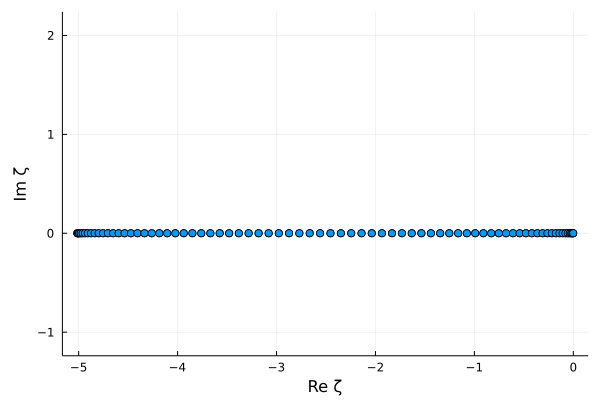

In [5]:
using LinearAlgebra
λ = eigvals(Matrix(Dxx))

scatter(real(τ*λ),imag(τ*λ),aspect_ratio=1,label="",
    xlabel="Re ζ",ylabel="Im ζ")

But $\bfA$ also has an $O(1)$ eigenvalue, which represents evolution in the ODE on the time scale $O(1)$. We will be forced to take $O(h^{-2})$ time steps to observe that scale. That is overkill from the standpoint of accuracy in this mode, but required by stability.

This situation is called **stiffness**. There is no accepted universal definition of the phenomenon, but it's characterized by the following:

1. Time steps that are more constrained by stability than by accuracy.
2. Inclusion of phenomena that evolve on time scales spanning orders of magnitude.
3. Implicit methods are much faster.

That last criterion appears because implicit methods have much larger stability regions than their explicit counterparts at the same order. They are also the only methods that can have unbounded stability regions.

In [6]:
@btime solve($ivp,Rodas4P(),abstol=1e-7,reltol=1e-7);

  34.302 ms (24195 allocations: 103.44 MiB)


In [7]:
sol = solve(ivp,Rodas4P(),abstol=1e-7,reltol=1e-7)
println("$(length(sol.t)) time steps taken")

117 time steps taken


The vastly smaller number of time steps more than makes up for the more expensive steps here.